# Twitter Sentiment Analysis

### Notebook Imports

In [67]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sn

import re
import string
import contractions
import emoji

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Constants

In [3]:
file_path = r'tweet_data.csv'

### Load the dataset

In [5]:
df = pd.read_csv("tweet_data.csv")

In [6]:
# Total number of tweets
print("Number of tweets: {}".format(len(df)))

Number of tweets: 18727


In [7]:
# Printing sample tweets
df.sample(10)

,textID,tweet_text,sentiment
12195,1695280598,"Gmorning ooh giirll, Mondays",positive
16785,1753216045,"aww thats wikid, i need to book myne again soo...",positive
17835,1753599602,"Right, is too glorious a day to be sat inside....",positive
10990,1694606280,@Blondie_HK very funny,positive
8297,1965694268,@LucySiebens I think they are disgusting,negative
16114,1752895765,@urbanlifepoetry haha. thanks for listening to...,positive
5590,1963370560,"@corylamb i was going tonight, but you never w...",negative
7963,1965458363,Thankful for last minute doc appointments... B...,positive
7632,1965256472,@Mitchelmusso: Am sad i got no money on my pho...,negative
16895,1753254685,second song is coming along nicley,positive


### Visualizing the distribution of the dataset

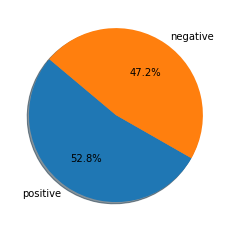

In [9]:
sentiment_count = df["sentiment"].value_counts()
plt.pie(sentiment_count, labels=sentiment_count.index,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.show()

In [10]:
# Number of positive and negative tweets
print("Number of + tweets: {}".format(df[df["sentiment"]=="positive"].count()[0]))
print("Number of - tweets: {}".format(df[df["sentiment"]=="negative"].count()[0]))

Number of + tweets: 9897
Number of - tweets: 8830


### Removing unwanted text

In [29]:
def replace_retweet(tweet, default_replace=""):
  tweet = re.sub('RT\s+', default_replace, tweet)
  return tweet

In [13]:
def replace_user(tweet, default_replace="twitteruser"):
  tweet = re.sub('\B@\w+', default_replace, tweet)
  return tweet

In [14]:
def demojize(tweet):
  tweet = emoji.demojize(tweet)
  return tweet

In [15]:
def replace_url(tweet, default_replace=""):
  tweet = re.sub('(http|https):\/\/\S+', default_replace, tweet)
  return tweet

In [16]:
def replace_hashtag(tweet, default_replace=""):
  tweet = re.sub('#+', default_replace, tweet)
  return tweet

In [17]:
def to_lowercase(tweet):
  tweet = tweet.lower()
  return tweet

In [18]:
def word_repetition(tweet):
  tweet = re.sub(r'(.)\1+', r'\1\1', tweet)
  return tweet

In [19]:
def punct_repetition(tweet, default_replace=""):
  tweet = re.sub(r'[\?\.\!]+(?=[\?\.\!])', default_replace, tweet)
  return tweet

In [32]:
def fix_contractions(tweet):
  tweet = contractions.fix(tweet)
  return tweet

### Tokenization

In [22]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to C:\Users\ONKAR
[nltk_data]     JOSHI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\ONKAR
[nltk_data]     JOSHI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [24]:
def custom_tokenize(tweet, keep_punct = False, keep_alnum = False, keep_stop = False):
  
  token_list = word_tokenize(tweet)

  if not keep_punct:
    token_list = [token for token in token_list if token not in string.punctuation]

  if not keep_alnum:
    token_list = [token for token in token_list if token.isalpha()]
  
  if not keep_stop:
    stop_words = set(stopwords.words('english'))
    stop_words.discard('not')
    token_list = [token for token in token_list if not token in stop_words]

  return token_list

### Stemming

In [25]:
def stem_tokens(tokens, stemmer):
  token_list = []
  for token in tokens:
    token_list.append(stemmer.stem(token))
  return token_list

### Process_Tweets function

In [26]:
def process_tweet(tweet, verbose=False):
  if verbose: print("Initial tweet: {}".format(tweet))

  ## Twitter Features
  tweet = replace_retweet(tweet) # replace retweet
  tweet = replace_user(tweet, "") # replace user tag
  tweet = replace_url(tweet) # replace url
  tweet = replace_hashtag(tweet) # replace hashtag
  if verbose: print("Post Twitter processing tweet: {}".format(tweet))

  ## Word Features
  tweet = to_lowercase(tweet) # lower case
  tweet = fix_contractions(tweet) # replace contractions
  tweet = punct_repetition(tweet) # replace punctuation repetition
  tweet = word_repetition(tweet) # replace word repetition
  tweet = demojize(tweet) # replace emojis
  if verbose: print("Post Word processing tweet: {}".format(tweet))

  ## Tokenization & Stemming
  tokens = custom_tokenize(tweet, keep_alnum=False, keep_stop=False) # tokenize
  stemmer = SnowballStemmer("english") # define stemmer
  stem = stem_tokens(tokens, stemmer) # stem tokens

  return stem

### Testing on a sample tweet

In [27]:
# Testing
complex_tweet = r"""RT @Anonymous : he looooook, 
THis is a big and complex TWeet!!! 👍 ... 
We'd be glad if you couldn't normalize it! 
Check https://t.co/7777 and LET ME KNOW!!! #NLP #Fun"""

In [35]:
print(process_tweet(complex_tweet, verbose=False))

['look', 'big', 'complex', 'tweet', 'would', 'glad', 'could', 'not', 'normal', 'check', 'let', 'know', 'nlp', 'fun']


### Apply process_tweet to the dataset

In [36]:
df["tokens"] = df["tweet_text"].apply(process_tweet)
df["tweet_sentiment"] = df["sentiment"].apply(lambda i: 1 if i == "positive" else 0)
df.head(10)

,textID,tweet_text,sentiment,tokens,tweet_sentiment
0,1956967666,Layin n bed with a headache ughhhh...waitin o...,negative,"[layin, n, bed, headach, call]",0
1,1956967696,Funeral ceremony...gloomy friday...,negative,"[funer, friday]",0
2,1956967789,wants to hang out with friends SOON!,positive,"[want, hang, friend, soon]",1
3,1956968477,Re-pinging @ghostridah14: why didn't you go to...,negative,"[not, go, prom, bf, not, like, friend]",0
4,1956968636,Hmmm. http://www.djhero.com/ is down,negative,[hmm],0
5,1956969035,@charviray Charlene my love. I miss you,negative,"[charlen, love, miss]",0
6,1956969172,@kelcouch I'm sorry at least it's Friday?,negative,"[sorri, least, friday]",0
7,1956969531,Choked on her retainers,negative,"[choke, retain]",0
8,1956970047,Ugh! I have to beat this stupid song to get to...,negative,"[ugh, beat, stupid, song, get, next, rude]",0
9,1956970424,@BrodyJenner if u watch the hills in london u ...,negative,"[watch, hill, london, realis, tourtur, week, w...",0


In [37]:
X = df["tokens"].tolist() # tweet tokens -- predictor
y = df["tweet_sentiment"].tolist() # tweet sentiment -- target

In [39]:
# print(X)
# print(y)

### Positive/Negative Frequency

#### Function used to create a dictionnary with the word and sentiment as index and the count of occurence as value

In [40]:
def build_freqs(tweet_list, sentiment_list):
  freqs = {}
  for tweet, sentiment in zip(tweet_list, sentiment_list):
    for word in tweet:
      pair = (word, sentiment)
      if pair in freqs:
        freqs[pair] += 1
      else:
        freqs[pair] = 1
  return freqs

In [41]:
freqs_all = build_freqs(X, y)

In [42]:
print("Frequency of word 'love' in + tweets: {}".format(freqs_all[("love", 1)]))
print("Frequency of word 'love' in - tweets: {}".format(freqs_all[("love", 0)]))

Frequency of word 'love' in + tweets: 1358
Frequency of word 'love' in - tweets: 67


#### Function used to convert tweets to a 2-d array by using the frequency dictionnary

In [59]:
def tweet_to_freq(tweet, freqs):
  x = np.zeros((2,))
  for word in tweet:
    if (word, 1) in freqs:
      x[0] += freqs[(word, 1)]
    if (word, 0) in freqs:
      x[1] += freqs[(word, 0)]
  return x

#### Plot word vectors in a chart and see where they locate

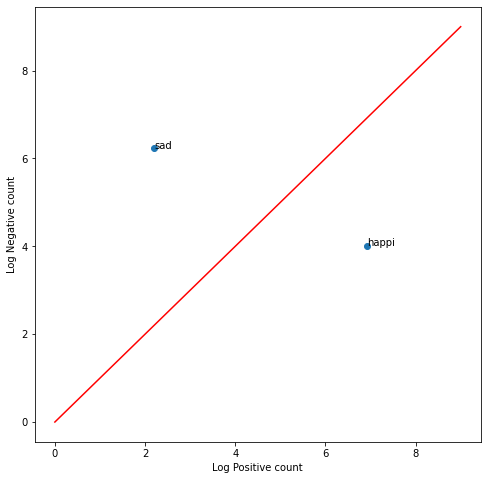

In [54]:
fig, ax = plt.subplots(figsize = (8, 8))

word1 = "happi" # testing for positive sentiment
word2 = "sad" # testing for negative sentiment

def word_features(word, freqs):
  x = np.zeros((2,))
  if (word, 1) in freqs:
    x[0] = np.log(freqs[(word, 1)] + 1)
  if (word, 0) in freqs:
    x[1] = np.log(freqs[(word, 0)] + 1)
  return x

x_axis = [word_features(word, freqs_all)[0] for word in [word1, word2]]
y_axis = [word_features(word, freqs_all)[1] for word in [word1, word2]]

ax.scatter(x_axis, y_axis)  

plt.xlabel("Log Positive count")
plt.ylabel("Log Negative count")

ax.plot([0, 9], [0, 9], color = 'red')
plt.text(x_axis[0], y_axis[0], word1)
plt.text(x_axis[1], y_axis[1], word2)
plt.show()

### Helper Function to plot Confusion matrix

In [48]:
def plot_confusion(cm):
  plt.figure(figsize = (5,5))
  sn.heatmap(cm, annot=True, cmap="Blues", fmt='.0f')
  plt.xlabel("Prediction")
  plt.ylabel("True value")
  plt.title("Confusion Matrix")
  return sn

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=0.80)

In [51]:
print("Size of X_train: {}".format(len(X_train)))
print("Size of y_train: {}".format(len(y_train)))
print("\n")
print("Size of X_test: {}".format(len(X_test)))
print("Size of y_test: {}".format(len(y_test)))
print("\n")
print("Train proportion: {:.0%}".format(len(X_train)/(len(X_train)+len(X_test))))

Size of X_train: 14981
Size of y_train: 14981


Size of X_test: 3746
Size of y_test: 3746


Train proportion: 80%


#### Function used to build the Bag-of-Words vectorizer with the corpus

In [55]:
def fit_cv(tweet_corpus):
  cv_vect = CountVectorizer(tokenizer=lambda x: x,
                            preprocessor=lambda x: x)
  cv_vect.fit(tweet_corpus)
  return cv_vect

#### Function used to build the TF-IDF vectorizer with the corpus

In [56]:
def fit_tfidf(tweet_corpus):
  tf_vect = TfidfVectorizer(preprocessor=lambda x: x,
                            tokenizer=lambda x: x)
  tf_vect.fit(tweet_corpus)
  return tf_vect

### Logistic Regression

In [53]:
def fit_lr(X_train, y_train):
  model = LogisticRegression()
  model.fit(X_train, y_train)
  return model

In [60]:
freqs = build_freqs(X_train, y_train)
X_train_pn = [tweet_to_freq(tweet, freqs) for tweet in X_train]
X_test_pn = [tweet_to_freq(tweet, freqs) for tweet in X_test]

In [61]:
model_lr_pn = fit_lr(X_train_pn, y_train)
print(model_lr_pn.coef_, model_lr_pn.intercept_)

[[ 0.00264615 -0.00194929]] [-0.55956082]


In [63]:
cv = fit_cv(X_train)
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

c:\Users\ONKAR JOSHI\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [64]:
model_lr_cv = fit_lr(X_train_cv, y_train)

In [65]:
tf = fit_tfidf(X_train)
X_train_tf = tf.transform(X_train)
X_test_tf = tf.transform(X_test)

c:\Users\ONKAR JOSHI\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\feature_extraction\text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [66]:
model_lr_tf = fit_lr(X_train_tf, y_train)

### Performance Metrics

In [68]:
y_pred_lr_pn = model_lr_pn.predict(X_test_pn)

In [69]:
print("LR Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_lr_pn)))

LR Model Accuracy: 77.92%


<module 'seaborn' from 'c:\\Users\\ONKAR JOSHI\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\seaborn\\__init__.py'>

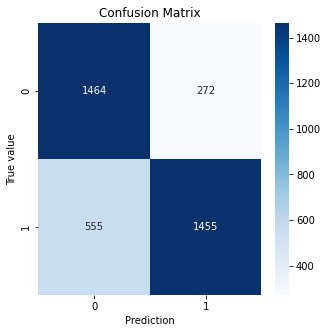

In [70]:
plot_confusion(confusion_matrix(y_test, y_pred_lr_pn))

In [72]:
y_pred_lr_cv = model_lr_cv.predict(X_test_cv)

In [73]:
print("LR Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_lr_cv)))

LR Model Accuracy: 88.52%


<module 'seaborn' from 'c:\\Users\\ONKAR JOSHI\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\seaborn\\__init__.py'>

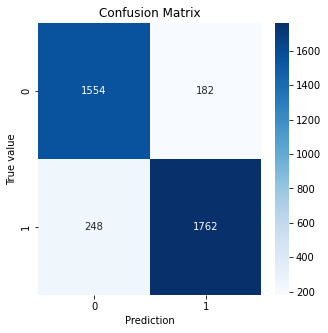

In [74]:
plot_confusion(confusion_matrix(y_test, y_pred_lr_cv))

In [75]:
y_pred_lr_tf = model_lr_tf.predict(X_test_tf)

In [76]:
print("LR Model Accuracy: {:.2%}".format(accuracy_score(y_test, y_pred_lr_tf)))

LR Model Accuracy: 88.65%


<module 'seaborn' from 'c:\\Users\\ONKAR JOSHI\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\seaborn\\__init__.py'>

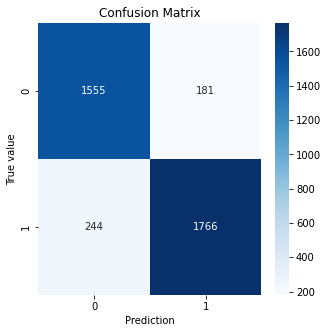

In [77]:
plot_confusion(confusion_matrix(y_test, y_pred_lr_tf))

### Pipeline

#### Function used to pre-process, transform and predict tweet sentiment

In [78]:
def predict_tweet(tweet):
  processed_tweet = process_tweet(tweet)
  transformed_tweet = tf.transform([processed_tweet])
  prediction = model_lr_tf.predict(transformed_tweet)

  if prediction == 1:
    return "Prediction is positive sentiment"
  else:
    return "Prediction is negative sentiment"